# <center> Modelo de ML </center>

## 1. Librerías

In [45]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import evaluate_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [46]:
warnings.simplefilter('ignore')

## 2. Configuraciones

In [47]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [48]:
plt.rcParams["figure.figsize"] = (8, 5)
sns.set_theme(style = "whitegrid")

## 3. Carga de datos

In [49]:
DATA_PATH = "../Data/Refined/Model input/refined_data.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (6870, 11)


,codCliente,codPoliza,Edad,Ramo,Y,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,37,69,31,Vida,Autos,0,1,0,0,0,0
1,37,80568,31,Autos,Salud,0,1,1,0,0,0
2,84,118023,41,Autos,Vida,0,0,1,0,0,0
3,87,54,42,Vida,Salud,0,1,0,0,0,0
4,1380,15380,36,Autos,Patrimoniales,0,0,1,0,0,0


## 4. Preprocesamiento de datos

### 4.1. Eliminar columnas de ID

In [50]:
id_cols = ["codCliente", "codPoliza"]
for col in id_cols:
    if col in df.columns:
        df = df.drop(columns = col)

In [51]:
df.drop(columns = ['Edad'], inplace = True)

### 4.2. Revisar desbalance entre clases

In [52]:
print(df["Y"].value_counts(normalize = True))

Y
Salud            0.346434
Vida             0.258952
Autos            0.220087
Patrimoniales    0.157351
Cumplimiento     0.014556
Otros            0.002620
Name: proportion, dtype: float64


### 4.3. Revisar nulos

In [53]:
df.isna().sum()

Ramo             0
Y                0
Salud            0
Vida             0
Autos            0
Cumplimiento     0
Patrimoniales    0
Otros            0
dtype: int64

## 5. Definición features y target

In [54]:
TARGET = "Y"

X = df.copy().drop(columns = TARGET)
y = df[TARGET].copy()

categorical_features = ["Ramo"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X.head()

,Ramo,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,Vida,0,1,0,0,0,0
1,Autos,0,1,1,0,0,0
2,Autos,0,0,1,0,0,0
3,Vida,0,1,0,0,0,0
4,Autos,0,0,1,0,0,0


## 6. División del conjunto de datos

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size: ", X_test.shape[0])

Train size: 5496
Test size:  1374


## 7. Pipelines de preprocesamiento

In [56]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

preprocess_for_linear = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", StandardScaler(), numeric_features),
    ]
)

preprocess_for_trees = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", "passthrough", numeric_features),
    ]
)

## 8. Modelos

### 8.1. Regresión logística

#### 8.1.1. Definición modelo

In [57]:
logreg_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_linear),
        ("model", LogisticRegression(
            max_iter = 1000,
            multi_class = "multinomial",
            n_jobs = -1,
            random_state = RANDOM_STATE,
        )),
    ]
)

#### 8.1.2. Ajuste de hiperparámetros

In [58]:
logreg_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__solver": ["lbfgs", "saga"],
}

logreg_grid_search = GridSearchCV(
    estimator = logreg_pipeline,
    param_grid = logreg_param_grid,
    cv = cv, 
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "f1_macro",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for Logistic Regression...")
logreg_grid_search.fit(X_train, y_train)

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.01, model__solver=saga; total time=   0.9s
[

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__solver': ['lbfgs', 'saga']}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'f1_macro'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.1.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5297
F1-macro: 0.2774

Classification report:
               precision    recall  f1-score   support

        Autos       0.64      0.11      0.19      1210
 Cumplimiento       0.00      0.00      0.00        80
        Otros       0.00      0.00      0.00        14
Patrimoniales       0.55      0.12      0.20       865
        Salud       0.54      0.77      0.63      1904
         Vida       0.51      0.84      0.63      1423

     accuracy                           0.53      5496
    macro avg       0.37      0.31      0.28      5496
 weighted avg       0.55      0.53      0.46      5496


Top-k metrics:
acc@1: 0.5297 | prec@1: 0.5297 | recall@1: 0.5297
acc@2: 0.8490 | prec@2: 0.4245 | recall@2: 0.8490
acc@3: 0.9834 | prec@3: 0.3278 | recall@3: 0.9834
acc@5: 0.9993 | prec@5: 0.1999 | recall@5: 0.9993


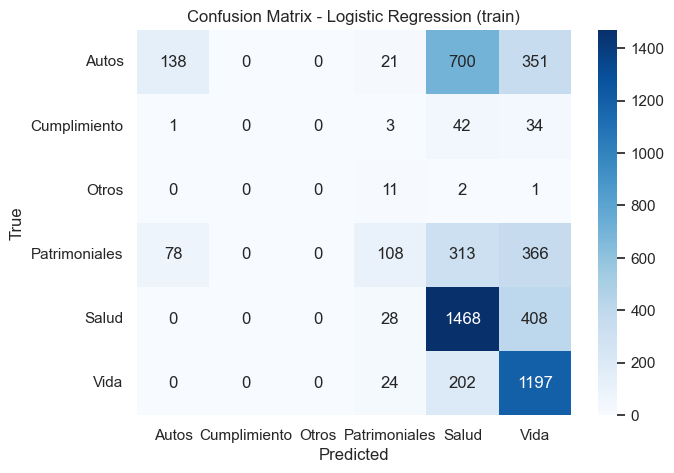

In [59]:
best_logreg_model = logreg_grid_search.best_estimator_
best_logreg_model.fit(X_train, y_train)

joblib.dump(best_logreg_model, "../Data/Refined/Model output/best_logreg_model.pkl")

logreg_train_results = evaluate_model("Logistic Regression (train)", best_logreg_model, X_train, y_train)

#### 8.1.4. Evaluación mejor modelo

Accuracy (k=1): 0.5204
F1-macro: 0.2774

Classification report:
               precision    recall  f1-score   support

        Autos       0.76      0.15      0.24       302
 Cumplimiento       0.00      0.00      0.00        20
        Otros       0.00      0.00      0.00         4
Patrimoniales       0.52      0.12      0.19       216
        Salud       0.52      0.74      0.61       476
         Vida       0.49      0.83      0.62       356

     accuracy                           0.52      1374
    macro avg       0.38      0.30      0.28      1374
 weighted avg       0.56      0.52      0.46      1374


Top-k metrics:
acc@1: 0.5204 | prec@1: 0.5204 | recall@1: 0.5204
acc@2: 0.8443 | prec@2: 0.4221 | recall@2: 0.8443
acc@3: 0.9818 | prec@3: 0.3273 | recall@3: 0.9818
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


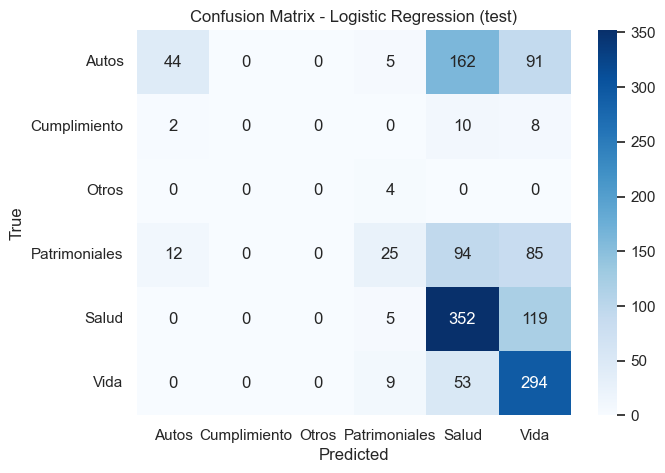

In [60]:
logreg_test_results = evaluate_model("Logistic Regression (test)", best_logreg_model, X_test, y_test)

### 8.2. HistGradientBoostingClassifier

#### 8.2.1. Definición del modelo

In [61]:
hgb_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_trees),
        ("model", HistGradientBoostingClassifier(random_state = RANDOM_STATE)),
    ]
)

#### 8.2.2. Ajuste de hiperparámetros

In [62]:
param_grid = {
    "model__max_depth": [None, 6, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__max_iter": [200, 400],
    "model__min_samples_leaf": [20, 50],
}

grid_search_hgb = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    cv = cv,
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "f1_macro",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for HistGradientBoosting...")
grid_search_hgb.fit(X_train, y_train)

Running GridSearchCV for HistGradientBoosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   2.9s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   2.9s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   2.9s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   3.4s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   3.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   3.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   3.5s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [None, 6, ...], 'model__max_iter': [200, 400], 'model__min_samples_leaf': [20, 50]}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'f1_macro'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.2.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5324
F1-macro: 0.2777

Classification report:
               precision    recall  f1-score   support

        Autos       0.64      0.12      0.20      1210
 Cumplimiento       0.00      0.00      0.00        80
        Otros       0.00      0.00      0.00        14
Patrimoniales       0.63      0.12      0.20       865
        Salud       0.54      0.78      0.64      1904
         Vida       0.51      0.85      0.64      1423

     accuracy                           0.53      5496
    macro avg       0.39      0.31      0.28      5496
 weighted avg       0.56      0.53      0.46      5496


Top-k metrics:
acc@1: 0.5324 | prec@1: 0.5324 | recall@1: 0.5324
acc@2: 0.8510 | prec@2: 0.4255 | recall@2: 0.8510
acc@3: 0.9840 | prec@3: 0.3280 | recall@3: 0.9840
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


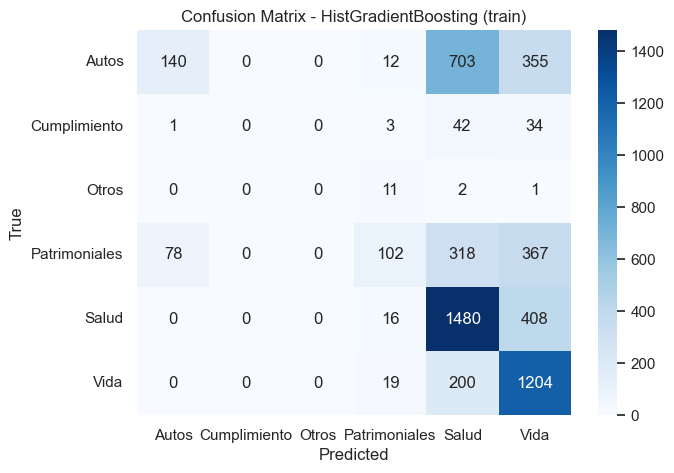

In [63]:
best_hgb_model = grid_search_hgb.best_estimator_
best_hgb_model.fit(X_train, y_train)

joblib.dump(best_hgb_model, "../Data/Refined/Model output/best_hgb_model.pkl")

hgb_train_results = evaluate_model("HistGradientBoosting (train)", best_hgb_model, X_train, y_train)

#### 8.2.4. Evaluación mejor modelo

Accuracy (k=1): 0.5233
F1-macro: 0.2935

Classification report:
               precision    recall  f1-score   support

        Autos       0.77      0.15      0.25       302
 Cumplimiento       1.00      0.05      0.10        20
        Otros       0.00      0.00      0.00         4
Patrimoniales       0.59      0.11      0.19       216
        Salud       0.53      0.74      0.62       476
         Vida       0.49      0.83      0.62       356

     accuracy                           0.52      1374
    macro avg       0.56      0.31      0.29      1374
 weighted avg       0.59      0.52      0.46      1374


Top-k metrics:
acc@1: 0.5233 | prec@1: 0.5233 | recall@1: 0.5233
acc@2: 0.8435 | prec@2: 0.4218 | recall@2: 0.8435
acc@3: 0.9811 | prec@3: 0.3270 | recall@3: 0.9811
acc@5: 0.9993 | prec@5: 0.1999 | recall@5: 0.9993


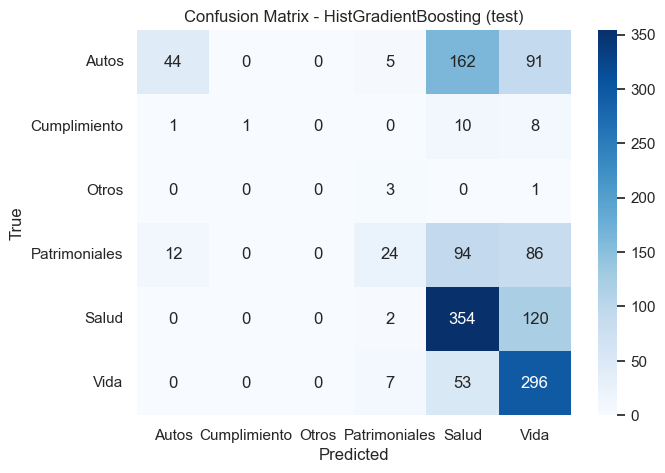

In [64]:
hgb_test_results = evaluate_model("HistGradientBoosting (test)", best_hgb_model, X_test, y_test)